## 성능 개선판 word2vec 학습모델 구현

### CBOW 모델 구현

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# import sys
# sys.path.insert(0,'/content/drive/My Drive/Word2Vec_test/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AG2WZGAIdaHgeLA1WQPvqiQ4Eu2g_r3voErN5a4p35Z-cYOX2Jwbm4
Mounted at /content/drive


In [ ]:
# import cupy as cp
# x = cp.arange(6).reshape(2,3).astype('f')

# x.sum()

# import cupy as np
# np.cuda.set_allocator(np.cuda.MemoryPool().malloc)
# # np.add.at = np.scatter_add

# print('\033[92m' + '-' * 60 + '\033[0m')
# print(' ' * 23 + '\033[92mGPU Mode (cupy)\033[0m')
# print('\033[92m' + '-' * 60 + '\033[0m\n')

In [ ]:
from nn_layers import  Embedding,EmbeddingDot, NegativeSamplingLoss, Adam, Trainer
from mynlp import  preprocess, most_similar, create_contexts_target 
import numpy as np


[[0.72883356 0.01295972 0.50190364 0.30644659 0.97393495 0.16901387
  0.61476532 0.87492164]] (1, 8)
----------------------------------------------------------------------
[[0.72883356 0.01295972 0.50190364 0.30644659 0.97393495 0.16901387
  0.61476532 0.87492164]
 [0.72883356 0.01295972 0.50190364 0.30644659 0.97393495 0.16901387
  0.61476532 0.87492164]
 [0.72883356 0.01295972 0.50190364 0.30644659 0.97393495 0.16901387
  0.61476532 0.87492164]
 [0.72883356 0.01295972 0.50190364 0.30644659 0.97393495 0.16901387
  0.61476532 0.87492164]
 [0.72883356 0.01295972 0.50190364 0.30644659 0.97393495 0.16901387
  0.61476532 0.87492164]
 [0.72883356 0.01295972 0.50190364 0.30644659 0.97393495 0.16901387
  0.61476532 0.87492164]
 [0.72883356 0.01295972 0.50190364 0.30644659 0.97393495 0.16901387
  0.61476532 0.87492164]] (7, 8)
[[0.19247529 0.61264622 0.81184074 0.7953551  0.86182934 0.59252088
  0.59758422 0.13067394]
 [0.41788432 0.78000426 0.49695835 0.95694474 0.61199649 0.66063513
  0.6058

In [ ]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

### CBOW 모델 학습 코드

In [ ]:
from dataset import ptb
import pickle

# 하이퍼파라미터 설정
window_size = 5
# window_size = 2

hidden_size = 100
batch_size = 100
max_epoch = 10  # 10회 이상

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')

# text = 'You say goodbye and I say hello.'
# corpus, word_to_id, id_to_word = preprocess(text)
# print(corpus) # 말뭉치

vocab_size = len(word_to_id)


contexts, target = create_contexts_target(corpus, window_size)
# if config.GPU:
#     contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs

params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params_epoch10.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)


###  CBOW 모델 평가

In [ ]:
# pkl_file = 'cbow_params.pkl'
pkl_file = 'cbow_params_epoch10.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

In [ ]:
def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [ ]:
# 유추(analogy) 작업
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

### SkipGram 모델 구현

In [ ]:
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None


### SkipGram 모델 학습 코드

In [ ]:
from dataset import ptb
import pickle

# 하이퍼파라미터 설정
window_size = 5
# window_size = 2

hidden_size = 100
batch_size = 100
max_epoch = 8  # 10회 이상

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')

# text = 'You say goodbye and I say hello.'
# corpus, word_to_id, id_to_word = preprocess(text)
# print(corpus) # 말뭉치

vocab_size = len(word_to_id)


contexts, target = create_contexts_target(corpus, window_size)
# if config.GPU:
#     contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
# model = CBOW(vocab_size, hidden_size, window_size, corpus)
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)


| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 41.59
| 에폭 1 |  반복 21 / 9295 | 시간 7[s] | 손실 41.58
| 에폭 1 |  반복 41 / 9295 | 시간 14[s] | 손실 41.48
| 에폭 1 |  반복 61 / 9295 | 시간 20[s] | 손실 41.04
| 에폭 1 |  반복 81 / 9295 | 시간 27[s] | 손실 39.98
| 에폭 1 |  반복 101 / 9295 | 시간 34[s] | 손실 38.42
| 에폭 1 |  반복 121 / 9295 | 시간 41[s] | 손실 37.04
| 에폭 1 |  반복 141 / 9295 | 시간 47[s] | 손실 35.69
| 에폭 1 |  반복 161 / 9295 | 시간 54[s] | 손실 34.43
| 에폭 1 |  반복 181 / 9295 | 시간 61[s] | 손실 33.52
| 에폭 1 |  반복 201 / 9295 | 시간 68[s] | 손실 32.64
| 에폭 1 |  반복 221 / 9295 | 시간 75[s] | 손실 32.47
| 에폭 1 |  반복 241 / 9295 | 시간 81[s] | 손실 31.64
| 에폭 1 |  반복 261 / 9295 | 시간 88[s] | 손실 31.39
| 에폭 1 |  반복 281 / 9295 | 시간 95[s] | 손실 31.03
| 에폭 1 |  반복 301 / 9295 | 시간 102[s] | 손실 30.55
| 에폭 1 |  반복 321 / 9295 | 시간 108[s] | 손실 30.28
| 에폭 1 |  반복 341 / 9295 | 시간 115[s] | 손실 30.19
| 에폭 1 |  반복 361 / 9295 | 시간 122[s] | 손실 29.92
| 에폭 1 |  반복 381 / 9295 | 시간 129[s] | 손실 29.74
| 에폭 1 |  반복 401 / 9295 | 시간 136[s] | 손실 29.76
| 에폭 1 |  반복 421 / 9295 | 시간 142[s] 

In [ ]:
% ls  ../
% pwd
% ls ./
% cd content/

bin/      dev/   lib32/  opt/   sbin/   tensorflow-1.15.2/  var/
boot/     etc/   lib64/  proc/  srv/    tmp/
content/  home/  media/  root/  swift/  tools/
datalab/  lib/   mnt/    run/   sys/    usr/
sample_data/
[Errno 2] No such file or directory: 'content/'
/content


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_

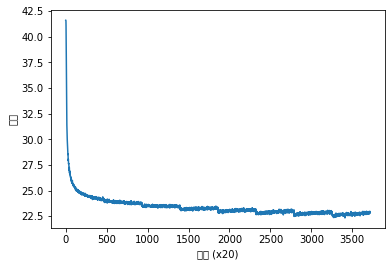

In [ ]:
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs

params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = '/content/drive/My Drive/Word2Vec_test/skipgram_params_epoch08.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [ ]:
# pkl_file = 'skipgram_params.pkl'
pkl_file = '/content/drive/My Drive/Word2Vec_test/skipgram_params_epoch08.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 yourself: 0.693359375
 anybody: 0.666015625
 i: 0.66015625
 somebody: 0.6328125
 your: 0.63134765625

[query] year
 month: 0.60986328125
 earlier: 0.5537109375
 week: 0.5419921875
 quarter: 0.541015625
 fiscal: 0.53759765625

[query] car
 cars: 0.65380859375
 luxury: 0.58203125
 mazda: 0.54638671875
 beretta: 0.52099609375
 truck: 0.51513671875

[query] toyota
 lexus: 0.7197265625
 honda: 0.68359375
 motor: 0.68115234375
 infiniti: 0.6787109375
 mazda: 0.6318359375
